# Protein Function Prediction
BioQuants course project by Federico Borra s319885

## Protein Function Definition using Gene Ontology generic slim
The first thing to do in order to develop a machine learning model to predict protein function is defining exactly what _protein function_ is.

To do it we use the Gene Ontology framework, in which one of the three main categories is, in fact, "molecular function".

Since the terms that are part of the "molecular function" category are too many we narrow down the prediction target by only considering the terms deemed "molecular function" in the GO generic slim subset of the Gene Ontology database.

The code below creates a dictionary with keys that are the molecular function terms in the generic slim and the values which are the set of all the descendants in the complete GO graph.
We use the python set data structure to obtain a $O(1)$ time complexity when checking if a term is part of it.

In [1]:
from ontobio.ontol_factory import OntologyFactory
ont = OntologyFactory().create("go")
slim = OntologyFactory().create("goslim_generic.json")

MOLECULAR_FUNCTION = "GO:0003674"

slim_go_terms = [el for el in list(slim.get_graph().nodes()) if el.startswith("GO")] # get all GO terms in generic slim set
molecular_functions = ont.descendants(MOLECULAR_FUNCTION) # get all molecular functions in GO
slim_molecular_functions = list(set(slim_go_terms) & set(molecular_functions)) # take intersection between molecular functions and slim GO terms
slim_molecular_functions_descendants = {el : set(ont.descendants(el)) for el in slim_molecular_functions} # get all descendants of the above

## UniProt Database
Now that we have a viable definition of what the prediction target is (in our case) we import the UniProt database.
Actually only a subset of it, namely the circa 20k human proteins.

We have downloaded this subset as a tsv file, selecting only the columns of interest, seen below.

In [2]:
import pandas as pd
import torch
import numpy as np

# this is a customized version of the UniProt database, only for human proteins, which are around 20k
# the columns were chosen to minimize the size of the file while maintaining useful information
df = pd.read_csv("uniprotkb_reviewed_true_AND_model_organ_2023_12_29.tsv", sep="\t")
df = df[~df['Gene Ontology (GO)'].isna()] # remove the ones without GO annotations

In [3]:
df = df[~df['Gene Ontology (molecular function)'].isna()] # remove the ones without GO annotations for molecular function
df.head()

,Entry,Entry Name,Protein names,Gene Names,Organism,Length,Sequence,Gene Ontology (molecular function),Gene Ontology (cellular component),Gene Ontology (biological process),Gene Ontology IDs,Gene Ontology (GO)
1,A0A024RBG1,NUD4B_HUMAN,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,Homo sapiens (Human),181,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,bis(5'-adenosyl)-hexaphosphatase activity [GO:...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,adenosine 5'-(hexahydrogen pentaphosphate) cat...,GO:0000298; GO:0003723; GO:0005634; GO:0005737...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...
28,A0A075B6Q5,HV364_HUMAN,Immunoglobulin heavy variable 3-64,IGHV3-64,Homo sapiens (Human),118,MMEFGLSWVFLVAIFKGVQCEVQLVESGEGLVQPGGSLRLSCAASG...,antigen binding [GO:0003823],extracellular region [GO:0005576]; immunoglobu...,immunoglobulin mediated immune response [GO:00...,GO:0003823; GO:0005576; GO:0005886; GO:0016064...,extracellular region [GO:0005576]; immunoglobu...
30,A0A075B6R2,HV404_HUMAN,Immunoglobulin heavy variable 4-4,IGHV4-4,Homo sapiens (Human),117,MKHLWFFLLLVAAPRWVLSQVQLQESGPGLVKPSGTLSLTCAVSGG...,antigen binding [GO:0003823],extracellular region [GO:0005576]; immunoglobu...,immunoglobulin mediated immune response [GO:00...,GO:0003823; GO:0005576; GO:0005886; GO:0016064...,extracellular region [GO:0005576]; immunoglobu...
38,A0A075B6T6,TVAL2_HUMAN,T cell receptor alpha variable 12-2,TRAV12-2,Homo sapiens (Human),113,MKSLRVLLVILWLQLSWVWSQQKEVEQNSGPLSVPEGAIASLNCTY...,peptide antigen binding [GO:0042605],T cell receptor complex [GO:0042101],adaptive immune response [GO:0002250],GO:0002250; GO:0042101; GO:0042605,T cell receptor complex [GO:0042101]; peptide ...
43,A0A075B6W5,TVA23_HUMAN,T cell receptor alpha variable 23/delta variab...,TRAV23DV6,Homo sapiens (Human),121,MDKILGASFLVLWLQLCWVSGQQKEKSDQQQVKQSPQSLIVQKGGI...,peptide antigen binding [GO:0042605],T cell receptor complex [GO:0042101],adaptive immune response [GO:0002250],GO:0002250; GO:0042101; GO:0042605,T cell receptor complex [GO:0042101]; peptide ...


We plot a histogram of the frequency of various sequence lengths in the database, we ascertain that most of the proteins have length below 1024, this information will be useful later on

<AxesSubplot:>

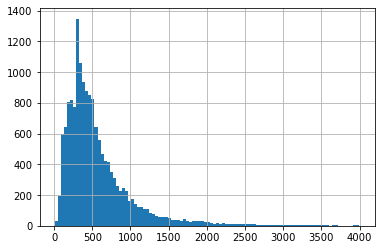

In [4]:
df[df['Length'] < 4000]['Length'].hist(bins=100) # below 4k, i.e. removing outliers

Now we do some data wrangling, in order to obtain a viable multilabel type DataFrame.

We first generate a list of the molecular functions (that are still relative to the full GO database).

We then assign True every label of the generic slim GO subset if one of the labels we obtained above is its descendant.

We then visualize the resulting DataFrame.

In [5]:
df['Gene Ontology (molecular function)'] = df['Gene Ontology (molecular function)']\
    .apply(lambda x: x.split(";")).apply(lambda x: [el[el.index("[GO")+1:-1] for el in x])

In [6]:
for k in slim_molecular_functions:
    df[ont.node(k)['label']] = df['Gene Ontology (molecular function)']\
        .apply(lambda x: max([True if el in slim_molecular_functions_descendants[k] else False for el in x]))

In [7]:
ohe_df = df.drop(columns=['Entry', 'Entry Name', 'Protein names', 'Gene Names', 'Organism',
                            'Length', 'Gene Ontology (molecular function)',
                            'Gene Ontology (cellular component)',
                            'Gene Ontology (biological process)', 'Gene Ontology IDs',
                            'Gene Ontology (GO)'])
ohe_df.head()

,Sequence,small molecule sensor activity,cyclase activity,catalytic activity,general transcription initiation factor activity,DNA binding,histone binding,transporter activity,cargo receptor activity,protein tag activity,...,toxin activity,cytoskeletal motor activity,transcription regulator activity,"catalytic activity, acting on a protein",hydrolase activity,transferase activity,molecular function regulator activity,lipid binding,antioxidant activity,cytoskeletal protein binding
1,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
28,MMEFGLSWVFLVAIFKGVQCEVQLVESGEGLVQPGGSLRLSCAASG...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30,MKHLWFFLLLVAAPRWVLSQVQLQESGPGLVKPSGTLSLTCAVSGG...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
38,MKSLRVLLVILWLQLSWVWSQQKEVEQNSGPLSVPEGAIASLNCTY...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
43,MDKILGASFLVLWLQLCWVSGQQKEKSDQQQVKQSPQSLIVQKGGI...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Lastly, we create a `labels` variable that we can use later to get back from the generic vectorial representation of the labels.

We also create said vectorial label representation, which we can then feed to a machine learning model

In [8]:
labels = ohe_df.drop(columns=["Sequence"]).columns
X = df[labels].to_numpy().astype(np.float32)
l = []
for i in range(X.shape[0]):
    l.append(torch.tensor(X[i,:]))

# LLM Fine Tuning (using a Logistic Regression as Classification Head)
This way we take advantage of Logistic Regression multivariate response and perform independent classification of all the various classes while having the gradients all flow through the same model, so as to obtain a better latent space representation of the various sequences.

First we create a `Dataset` object with the vectorial representation of the labels and the relative sequence, then we shuffle (using a seed, 42) and split it in train and test partitions.

In [9]:
from datasets import Dataset

ds = Dataset.from_dict({"labels": l, "sequence" : df['Sequence']})
ds = ds.shuffle(seed=42).train_test_split(test_size=0.2, seed=42) # both shuffle and split need seed to guarentee determinism, that we need to do training some epochs at a time
ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'sequence'],
        num_rows: 12817
    })
    test: Dataset({
        features: ['labels', 'sequence'],
        num_rows: 3205
    })
})

We instantiate a pre-trained model, ESM, found at https://huggingface.co/docs/transformers/model_doc/esm

It's a transformer based architecture pre-trained on a classical masked language modeling task (predict a given token, in thin case amminoacid in a sequence, given the surrounding context) employing the famous self-attention mechanism.

Given the scarce computational resources at our disposal we use the version of the model wth 8 million parameters, although it can go up to 15 billion, which would undoubtedly perform better.

In [10]:
from transformers import AutoTokenizer, EsmModel
import torch
import os

os.environ['TOKENIZERS_PARALLELISM'] = "false"
os.environ["WANDB_DISABLED"] = "true" # disable remote logging

checkpoint = "facebook/esm2_t6_8M_UR50D"

BATCH_SIZE = 4
NUM_EPOCHS = 20

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = EsmModel.from_pretrained(checkpoint)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We tokenize the sequences. As is typical in LLM finetuning we "freeze" the tokenizer, i.e. we do not train the model that produces the embeddings of single tokens but only the language model afterwards which "shifts" the vector representation of the token depending on the surrounding ones.

In [11]:
def preprocess_tokenize(mapped_ds):
    return tokenizer(mapped_ds['sequence'], truncation=True, max_length=1024)

ds = ds.map(preprocess_tokenize)
ds = ds.remove_columns("sequence")
ds

Map:   0%|          | 0/12817 [00:00<?, ? examples/s]

Map:   0%|          | 0/3205 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 12817
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3205
    })
})

Now we add to the ESM encoder a custom multilabel classification head: the component we call `self.clf` in the model definition.

We create a subclass of the `torch.nn.Module` class for this purpose.

Moreover we need to define a `MultilabelTrainer` which is a subclass of Huggingface's `transformers.Trainer` base class. Here we need to override the `compute_loss` method to adapt the `BCELoss` to the multilabel use case.

In [12]:
#import pytorch_lightning as pl
import torch.nn as nn
from transformers import Trainer, TrainingArguments

class ESMwithMultiClass(nn.Module):
    def __init__(self, num_labels=40, lr=1e-4):
        super().__init__()
        self.llm = model
        self.num_labels = num_labels
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(in_features=model.pooler.dense.in_features, out_features=self.num_labels),
            nn.Sigmoid()
        )
        self.lr = lr

    def forward(self, input_ids, attention_mask, labels=None):
        return {'logits': self.clf(self.llm(input_ids, attention_mask).pooler_output)}
    
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        logits = model(**inputs)['logits']
        #logits = outputs.get('logits')
        loss_fct = nn.BCELoss()
        loss = loss_fct(logits.view(-1, self.model.num_labels),
                        labels.float().view(-1, self.model.num_labels))
        loss = loss.mean()
        return (loss, model(**inputs)) if return_outputs else loss

Lastly, we define some metrics in the `compute_metrics` function. 

Namely, an _F1_ score that is the average of the F1 scores for the various classes (like "DNA binding") on their own.

We also define a Hamming distance which we then average (implemented with a logical xor since the predictions are taken from a binary alphabet).
It has a nice interpretation: the average number of wrong predictions (be they false negative or false positive) per sample.

In [13]:
import evaluate
from transformers import DataCollatorWithPadding
from typing import List, Dict, Any

def compute_metrics(eval_pred):
    f1_score = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.where(predictions > 0.5, 1, 0)
    labels = np.where(labels > 0.5, 1, 0)
    f1s = []
    for i in range(40):
        f1s.append(f1_score.compute(predictions=predictions[:, i], references=labels[:, i], average="macro")['f1'])
    average_wrongs = np.logical_xor(predictions, labels).sum(axis=1).mean()
    return {'f1_average' : sum(f1s) / len(f1s), 'hamming_distance' : float(average_wrongs)}

We then set some training arguments such as weight decay and saving and evaluation strategies. We also instatiate our custom `MultilabelTrainer`

In [14]:
training_args = TrainingArguments(
    output_dir="./esm_multilabel",
    learning_rate=1e-4,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    #load_best_model_at_end=True,
    report_to="none",
    logging_steps=1,
)

esm = ESMwithMultiClass()

trainer = MultilabelTrainer( # can you belive that it drops columns that are not explicitly used by the model? damned huggingface 
        model=esm,
        args=training_args,
        train_dataset=ds["train"],
        eval_dataset=ds["test"],
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
    )

We now proceed to train the model (typically we train a few epochs at a time, save then resume training)

In [15]:
import os

# this takes the last available checkpoint and resumes training from there
trainer.train(resume_from_checkpoint=f"esm_multilabel/{sorted(os.listdir('esm_multilabel'))[-1]}/")

Epoch,Training Loss,Validation Loss,F1 Average,Hamming Distance
16,0.065900,0.095776,0.687014,0.917005
17,0.033900,0.098796,0.704342,0.918877
18,0.024200,0.102625,0.714758,0.899844
19,0.018900,0.105940,0.714417,0.893604
20,0.015800,0.107446,0.723951,0.888300


TrainOutput(global_step=64100, training_loss=0.007934880844330453, metrics={'train_runtime': 2346.0169, 'train_samples_per_second': 109.266, 'train_steps_per_second': 27.323, 'total_flos': 0.0, 'train_loss': 0.007934880844330453, 'epoch': 20.0})

As you can see from the columns "F1 Average" and "Hamming Distance", which are calculated on the test set, the models performs quite well.

Of course with some hyperparameter tuning and more computational resources, so as to be able to use bigger models and more data, the results could be even more impressive

We finally better quantify the model's performance by employing a multi-label confusion matrix, as described in [Heydarian et al, MLCM: Multi-Label Confusion Matrix](https://www.researchgate.net/publication/358509618_MLCM_Multi-Label_Confusion_Matrix). This is basically the equivalent of a normal confusion matrix but with an additional row and column to signify the absence of all other labels.

On the y-axis we have the ground truth and on the x-axis we have the assigned label.

As we can see from the matrix when the model fails it mostly assigns other (i.e. no label) to any given class. This is not surprising given the nature of the model, which is one-vs-all logistic regression.

<AxesSubplot:>

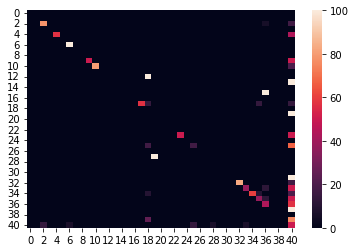

In [16]:
from mlcm import mlcm
import seaborn as sns

predictions, _, _ = trainer.predict(ds["test"].select(range(50)))
predictions = np.where(predictions > .5, 1, 0)
references = np.array(ds["test"].select(range(50))['labels'])

conf_mat,normal_conf_mat = mlcm.cm(references, predictions, print_note=False)
sns.heatmap(normal_conf_mat)

It's interesting to note that, for example, two classes that are often confused are labels at index 19 and 27, which are the following

In [18]:
labels[19], labels[27]

('catalytic activity, acting on DNA', 'catalytic activity, acting on RNA')

It's not surprising to see these two categories mixed up due to obvious reasons.

Other classes often confused are the following. We lack expertise to ascertain their actual biochemical relatedness.

In [19]:
labels[12], labels[18]

('protein folding chaperone', 'ligase activity')

In [20]:
labels[15], labels[36]

('molecular adaptor activity', 'molecular function regulator activity')